<div style="border: 2px solid goldenrod; background-color: darkblue; padding: 15px; border-radius: 10px; font-family: Arial; font-size: 16px;">
    <h1 style="color: goldenrod; margin-bottom: 10px;">CONTUGAS MODEL COMPARISON</h1>
    <p style="color: goldenrod; font-weight: bold;">Preparado por Grupo CORJ-2514</p>
</div>

### Packages Installation

In [25]:
# Installing packages
#%pip install pandas numpy scipy matplotlib seaborn plotly
# Machine learning libraries
#%pip install scikit-learn tensorflow keras torch
# Statistical analysis
#%pip install statsmodels
# Geospatial data
#%pip install geopandas rasterio shapely
# Interactive Jupyter enhancements
#%pip install jupyterlab ipywidgets
#%pip install tabulate
# Install tensorflow
#%pip install tensorflow

In [52]:
# Data Manipulation
# ------------------------------------------------------------------------------
import numpy as np                # arrays and matrices library
import pandas as pd               # pandas library for data analysis and manipulation tool
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
from typing import Dict, List, Tuple
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, losses, optimizers
from tensorflow.keras.layers import LeakyReLU

# Plots
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt   # mapplotlib library for creating static, animated, and interactive visualization
import seaborn as sns             # seaborn library for data visualization library based on matplotlib
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go # plotly library for interactive graphing library
import plotly.express as px       # plotly express for high-level interface for plotly
from IPython.display import display, DisplayHandle, clear_output

# Warnings Configuration
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Others
# ------------------------------------------------------------------------------
import os
import random
import time
import sys

In [27]:
print (' ')
print ('The versions of the python packages are given as follows:')
print (' ')
print ('Numpy version     :', np.__version__)
print ('Pandas version    :', pd.__version__)
print ('Tensorflow version    :', tf.__version__)
print ('Python version    :', sys.version_info)

 
The versions of the python packages are given as follows:
 
Numpy version     : 2.0.2
Pandas version    : 2.2.3
Tensorflow version    : 2.18.0
Python version    : sys.version_info(major=3, minor=11, micro=7, releaselevel='final', serial=0)


### Configuraciones Generales

In [28]:
# Aumentar el número de filas y columnas visibles en el output
pd.options.display.max_rows = 100   # Número máximo de filas visibles
pd.options.display.max_columns = 30  # Número máximo de columnas visibles
# Aumentar el número de filas y columnas que se muestran en el output
pd.options.display.max_rows = None    # Muestra todas las filas
pd.options.display.max_columns = None # Muestra todas las columnas

In [54]:
# %% [SETUP]
# Reproducibilidad
SEED = 69069
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Archivo de entrada consolidado por el ETL
CSV_PATH = "df_contugas.csv"

# Escenarios de inyección de anomalías (entre baseline y stress)
ANOM_RATES = [0.01, 0.05]  # 1% (target) y 5% (con estrés) de anomalías

# Lags utilizados (incluye patrón diario si la frecuencia es horaria)
LAGS = (1, 24, 48, 72, 168)  # lags de 1h, 1d, 2d y 7d

# Parámetros LSTM
#SEQ_LEN_CANDIDATES = (24, 48, 72, 168)  # longitudes de secuencia a probar (24h, 48h, 72h, 168h)
SEQ_LEN = 48                             # longitud de la ventana temporal (nº de pasos de tiempo por secuencia)
LSTM_UNITS1 = 32                         # nº de unidades en la capa LSTM1 (capacidad de memoria del modelo)
LSTM_UNITS2 = 16                         # nº de unidades en la capa LSTM2 (capacidad de memoria del modelo)
DENSE_UNITS = 16                         # nº de neuronas en la capa densa intermedia (proyección no lineal)
BATCH_SIZE = 256                         # tamaño de mini-lote para el entrenamiento (muestras por actualización)
EPOCHS = 30                              # máximo de épocas de entrenamiento (pasadas completas por el conjunto)
EARLY_STOP_PATIENCE = 5                  # paciencia del early stopping: épocas sin mejora en val_loss antes de parar

#### Funciones Generales

In [44]:
# Utils
def add_lags_by_client(df: pd.DataFrame,
                       cols: Tuple[str, ...] = ("Volumen", "Presion", "Temperatura"),
                       lags: Tuple[int, ...] = (1,)) -> pd.DataFrame:
    out = df.sort_values(["Cliente", "Fecha"]).copy()
    for L in lags:
        for c in cols:
            out[f"{c}_lag{L}"] = out.groupby("Cliente", group_keys=False)[c].shift(L)
    return out

def add_time_cyc(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["hora"] = out["Fecha"].dt.hour
    out["hora_sin"] = np.sin(2 * np.pi * out["hora"] / 24.0)
    out["hora_cos"] = np.cos(2 * np.pi * out["hora"] / 24.0)
    return out

def robust_z(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, float)
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return (x - med) / mad

def cov_inv_stable(E: np.ndarray, ridge: float = 1e-6) -> np.ndarray:
    C = np.cov(E.T)
    C = C + ridge * np.eye(C.shape[0])
    return np.linalg.inv(C)

def mahalanobis_rows(E: np.ndarray, Cinv: np.ndarray) -> np.ndarray:
    # E: (n, d); Cinv: (d, d)
    return np.sqrt(np.sum((E @ Cinv) * E, axis=1))

def threshold_at_fpr(scores: np.ndarray, idx_normal: np.ndarray, fpr: float = 0.01) -> float:
    base = np.asarray(scores)[idx_normal]
    return float(np.quantile(base, 1.0 - fpr))

def temporal_split(df: pd.DataFrame, frac_train: float = 0.8) -> Tuple[pd.DataFrame, pd.DataFrame]:
    n = len(df)
    cut = int(n * frac_train)
    return df.iloc[:cut].copy(), df.iloc[cut:].copy()

### Data Entry

In [55]:
# Data
df = pd.read_csv('df_contugas.csv', 
                 header=0,
                 sep=',',
                 index_col=None,
                 usecols=None,
                 na_values=['', 'NA', 'NULL', '-'],
                 nrows=None,
                 encoding='utf-8-sig')

# Convertir la columna 'Fecha' a tipo datetime
#df['Fecha'] = pd.to_datetime(df['Fecha'])
# Configurar la columna 'Fecha' como índice
#df.set_index('Fecha', inplace=True)
#df = df.sort_index()  # Ordenar
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847946 entries, 0 to 847945
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Fecha        847946 non-null  object 
 1   Cliente      847946 non-null  object 
 2   Segmento     847946 non-null  object 
 3   Presion      847946 non-null  float64
 4   Temperatura  847946 non-null  float64
 5   Volumen      847946 non-null  float64
dtypes: float64(3), object(3)
memory usage: 38.8+ MB


In [56]:
# Basic Cleaning
required = {"Fecha", "Cliente", "Segmento", "Volumen", "Presion", "Temperatura"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
for c in ["Volumen", "Presion", "Temperatura"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["Fecha", "Cliente", "Segmento", "Volumen", "Presion", "Temperatura"])
df = df.sort_values(["Cliente", "Fecha"]).reset_index(drop=True)

# Features temporales
df = add_lags_by_client(df, lags=LAGS)
df = add_time_cyc(df)

# Conjunto mínimo de features y objetivo para los modelos basados en pronóstico
FEATS_LAGS = [f"{v}_lag{L}" for v in ("Volumen","Presion","Temperatura") for L in LAGS]
FEATS_TIME = ["hora_sin", "hora_cos"]
TARGETS = ["Volumen", "Presion", "Temperatura"]

# Filtrado por NAs generados por lags
df = df.dropna(subset=FEATS_LAGS + FEATS_TIME + TARGETS)

### Notas Operativas

1. Entrenamiento por Segmento: cada modelo se ajusta con el histórico del segmento (Comercial/Industrial) y se calibra por cliente en la evaluación mediante umbrales con FPR≈1% por cliente.

2. Señales temporales: hora_sin, hora_cos capturan periodicidad diaria; los lags (1, 24) incorporan memoria y patrón de 24 h en modelos de pronóstico (Ridge).

3. LSTM usa ventana SEQ_LEN=24 con señales actuales y cíclicas; el score es Mahalanobis de residuales en 3-D.

4. Isolation Forest usa un snapshot enriquecido [actuales + lags + cíclicas] y su score se estandariza con z-robusto para comparabilidad.

5. Inyección 1% y 3%: por cliente, con separación mínima entre eventos y magnitud modulada por la desviación estándar del segmento.

6. Métrica principal: Recall@FPR≈1% en macro-promedio sobre clientes dentro de cada segmento y luego macro sobre segmentos.

7. Severidad: media del score en anómalos; sirve para priorización en el dashboard.

### Inyección de Anomalías (por cliente y multivariable)

In [57]:
# Simulación de anomalías (por cliente y multivariable)
rng = np.random.default_rng(SEED)

def inject_anomalies_by_client(test_df: pd.DataFrame,
                               rate: float,
                               seg_stats: Dict[str, Dict[str, float]],
                               min_gap: int = 24) -> Tuple[pd.DataFrame, Dict[str, np.ndarray]]:
    """
    Inyecta anomalías multivariables por cliente en test_df.
    Tipos base: pico (up/down), desplazamiento, deriva/tendencia, linea plana, desacoplamiento (Volumen↑ con Presion↓).
    Tipos añadidos: presion_cero_con_volumen (P=0 con V>0),
                    volumen_p99 (V > p99 del segmento),
                    presion_p99 (P > p99 del segmento),
                    temperatura_alta30 (T > 30°C sostenida).
    Magnitudes escaladas por std del segmento; respeta separación mínima entre eventos.
    Retorna:
        - DataFrame modificado
        - dict cliente(str) -> índices absolutos anómalos (np.ndarray respecto a test_df)
    """
    out = test_df.copy()
    anom_idx_map: Dict[str, List[int]] = {}

    for cli, g in out.groupby("Cliente", sort=False):
        cli_str = str(cli)
        g = g.sort_values("Fecha")
        n = len(g)
        if n == 0:
            anom_idx_map[cli_str] = []
            continue

        # número de eventos según tasa
        k = max(1, int(np.floor(rate * n)))
        mask_block = np.zeros(n, dtype=bool)
        idxs: List[int] = []

        # std por segmento (entran desde seg_stats)
        seg = str(g["Segmento"].iloc[0])
        std_vol = float(seg_stats[seg]["Volumen_std"])
        std_pre = float(seg_stats[seg]["Presion_std"])
        std_tmp = float(seg_stats[seg]["Temperatura_std"])

        # percentiles 99% por segmento (calculados sobre todo test_df del mismo segmento)
        seg_mask = (out["Segmento"] == seg)
        try:
            p99_vol_seg = float(np.nanpercentile(out.loc[seg_mask, "Volumen"].to_numpy(dtype="float64", na_value=np.nan), 99))
        except Exception:
            p99_vol_seg = float(np.nanmax(out.loc[seg_mask, "Volumen"])) if seg_mask.any() else 0.0
        if not np.isfinite(p99_vol_seg):
            p99_vol_seg = 0.0

        try:
            p99_pre_seg = float(np.nanpercentile(out.loc[seg_mask, "Presion"].to_numpy(dtype="float64", na_value=np.nan), 99))
        except Exception:
            p99_pre_seg = float(np.nanmax(out.loc[seg_mask, "Presion"])) if seg_mask.any() else 0.0
        if not np.isfinite(p99_pre_seg):
            p99_pre_seg = 0.0

        # Repartición: mitad puntuales, mitad por ventanas
        k_point = k // 2
        k_window = k - k_point

        # --- Puntuales (spikes) ---
        tries = 0
        while len(idxs) < k_point and tries < 5 * k_point:
            i = int(rng.integers(0, n))
            # respetar ventana de exclusión alrededor del índice
            if mask_block[max(0, i - min_gap // 2):min(n, i + min_gap // 2)].any():
                tries += 1
                continue

            var = rng.choice(["Volumen", "Presion", "Temperatura"])
            mode = rng.choice(["up", "down"])
            fac_up = rng.uniform(1.8, 2.5)
            fac_dn = rng.uniform(0.3, 0.6)

            base = float(g[var].iloc[i])
            if var == "Volumen":
                newv = base * (fac_up if mode == "up" else fac_dn)
                # probabilidad de forzar por encima del p99 del segmento en un punto
                if rng.random() < 0.25:
                    newv = max(newv, p99_vol_seg * rng.uniform(1.02, 1.20))
            elif var == "Presion":
                newv = base + (2.5 * std_pre if mode == "up" else -2.0 * std_pre)
                # probabilidad de forzar por encima del p99 del segmento en un punto
                if rng.random() < 0.25 and mode == "up":
                    newv = max(newv, p99_pre_seg * rng.uniform(1.02, 1.15))
            else:  # Temperatura
                newv = base + (2.0 * std_tmp if mode == "up" else -2.0 * std_tmp)
                # asegurar ocasionalmente > 30°C
                if rng.random() < 0.2:
                    newv = max(newv, 30.0 + rng.uniform(0.5, 6.0))

            out.loc[g.index[i], var] = float(max(newv, 0.0))
            mask_block[i] = True
            idxs.append(i)
            tries += 1

        # --- Ventanas (shift/drift/flatline/desacople + casos nuevos) ---
        tries = 0
        win_events = 0
        while win_events < k_window and tries < 10 * k_window:
            length = int(rng.integers(3, 12))
            start = int(rng.integers(0, max(1, n - length)))
            end = start + length
            # respetar separación mínima entre eventos
            if mask_block[max(0, start - min_gap):min(n, end + min_gap)].any():
                tries += 1
                continue

            # catálogo de eventos de ventana
            kind = rng.choice([
                "shift", "drift", "flatline", "desacople",
                "presion_cero_con_volumen",
                "volumen_p99",
                "presion_p99",
                "temperatura_alta30"
            ])
            var = rng.choice(["Volumen", "Presion", "Temperatura"])
            seg_chunk = g.iloc[start:end]
            idx_range = list(range(start, end))

            if kind == "shift":
                if var == "Volumen":
                    delta = 1.5 * std_vol
                elif var == "Presion":
                    delta = 1.5 * std_pre
                else:
                    delta = 1.5 * std_tmp
                arr = seg_chunk[var].to_numpy(dtype="float64", na_value=np.nan)
                new_arr = np.maximum(arr + float(delta), 0.0)
                out.loc[seg_chunk.index, var] = new_arr

            elif kind == "drift":
                if var == "Volumen":
                    amp = 2.0 * std_vol
                elif var == "Presion":
                    amp = 2.0 * std_pre
                else:
                    amp = 2.0 * std_tmp
                arr = seg_chunk[var].to_numpy(dtype="float64", na_value=np.nan)
                drift = np.linspace(0.0, float(amp), len(seg_chunk), dtype="float64")
                new_arr = np.maximum(arr + drift, 0.0)
                out.loc[seg_chunk.index, var] = new_arr

            elif kind == "flatline":
                arr = seg_chunk[var].to_numpy(dtype="float64", na_value=np.nan)
                const = float(np.nanmedian(arr))
                out.loc[seg_chunk.index, var] = max(const, 0.0)

            elif kind == "desacople":  # Volumen ↑, Presion ↓ sostenidos
                v_arr = seg_chunk["Volumen"].to_numpy(dtype="float64", na_value=np.nan)
                p_arr = seg_chunk["Presion"].to_numpy(dtype="float64", na_value=np.nan)
                out.loc[seg_chunk.index, "Volumen"] = np.maximum(v_arr + 2.0 * std_vol, 0.0)
                out.loc[seg_chunk.index, "Presion"]  = np.maximum(p_arr - 2.0 * std_pre, 0.0)

            # ------- OTROS CASOS -------
            elif kind == "presion_cero_con_volumen":
                v_arr = seg_chunk["Volumen"].to_numpy(dtype="float64", na_value=np.nan)
                out.loc[seg_chunk.index, "Presion"] = 0.0
                out.loc[seg_chunk.index, "Volumen"] = np.maximum(v_arr + 1.0 * std_vol, 0.0)

            elif kind == "volumen_p99":
                # forzar Volumen por encima del p99 del segmento durante la ventana
                target_v = p99_vol_seg * rng.uniform(1.02, 1.30)
                out.loc[seg_chunk.index, "Volumen"] = np.maximum(target_v, 0.0)

            elif kind == "presion_p99":
                # forzar Presion por encima del p99 del segmento durante la ventana
                target_p = p99_pre_seg * rng.uniform(1.02, 1.20)
                out.loc[seg_chunk.index, "Presion"] = np.maximum(target_p, 0.0)

            elif kind == "temperatura_alta30":
                t_arr = seg_chunk["Temperatura"].to_numpy(dtype="float64", na_value=np.nan)
                base = 30.0 + rng.uniform(0.5, 6.0)
                new_arr = np.maximum(t_arr, base + 0.5 * std_tmp)
                out.loc[seg_chunk.index, "Temperatura"] = new_arr

            # --------------------------------

            mask_block[max(0, start):min(n, end)] = True
            idxs.extend(idx_range)
            win_events += 1
            tries += 1

        # índices de anomalía locales por cliente
        anom_idx_map[cli_str] = np.unique(np.array(idxs, dtype=int)).tolist()

    # Mapear índices locales a índices absolutos del test_df (llaves normalizadas a str)
    abs_map: Dict[str, np.ndarray] = {}
    for cli, g in out.groupby("Cliente", sort=False):
        cli_str = str(cli)
        local = anom_idx_map.get(cli_str, [])
        abs_map[cli_str] = g.index.to_numpy()[np.array(local, dtype=int)] if len(local) else np.array([], dtype=int)

    return out, abs_map

### Preparación por Segmento y Estadísticas de Escala

In [58]:
# Preparación por Segmento y Estadísticas de Escala
segments = sorted(df["Segmento"].unique())
seg_stats: Dict[str, Dict[str, float]] = {}

for seg in segments:
    g = df[df["Segmento"] == seg]
    seg_stats[seg] = {
        "Volumen_std": float(g["Volumen"].std(ddof=0)),
        "Presion_std": float(g["Presion"].std(ddof=0)),
        "Temperatura_std": float(g["Temperatura"].std(ddof=0)),
    }

# División temporal global y luego segmentación (mantiene orden temporal total)
full_train, full_test = temporal_split(df, frac_train=0.70)

In [37]:
# Export de anomalías inyectadas con flag is_anomaly
# Inyección con tasa 1%
# Definir test_df desde el split temporal
test_df = full_test.copy()
out_1, abs_map_1 = inject_anomalies_by_client(test_df, rate=0.01, seg_stats=seg_stats)
out_1_flag = out_1.copy()
out_1_flag["is_anomaly"] = 0

if abs_map_1:
    idx_all_1 = np.concatenate([v for v in abs_map_1.values() if isinstance(v, np.ndarray) and v.size > 0]) \
                if any((isinstance(v, np.ndarray) and v.size > 0) for v in abs_map_1.values()) else np.array([], dtype=int)
    if idx_all_1.size > 0:
        out_1_flag.loc[np.unique(idx_all_1), "is_anomaly"] = 1

out_1_flag.to_csv("anomalies_injected_1pct.csv", index=False, encoding="utf-8-sig")

# Inyección con tasa 5%
out_5, abs_map_5 = inject_anomalies_by_client(test_df, rate=0.05, seg_stats=seg_stats)
out_5_flag = out_5.copy()
out_5_flag["is_anomaly"] = 0

if abs_map_5:
    idx_all_5 = np.concatenate([v for v in abs_map_5.values() if isinstance(v, np.ndarray) and v.size > 0]) \
                if any((isinstance(v, np.ndarray) and v.size > 0) for v in abs_map_5.values()) else np.array([], dtype=int)
    if idx_all_5.size > 0:
        out_5_flag.loc[np.unique(idx_all_5), "is_anomaly"] = 1

out_5_flag.to_csv("anomalies_injected_5pct.csv", index=False, encoding="utf-8-sig")

### Modelos Ridge and Isolation Forest: Ajuste por Segmento Cliente

In [59]:
# Model Training — Ridge Regression & Isolation Forest Multivariable
# Estructuras para almacenar artefactos por segmento
ridge_models = {}
ridge_scalers = {}
ridge_Cinv = {}
if_models = {}
if_scalers = {}

# Conjuntos de features para cada detector
RIDGE_XCOLS = FEATS_LAGS + FEATS_TIME
IF_XCOLS = TARGETS + FEATS_LAGS + FEATS_TIME

for seg in segments:
    tr = full_train[full_train["Segmento"] == seg].copy()
    te = full_test[full_test["Segmento"] == seg].copy()

    # ----- RIDGE (L2) (multi-salida) -----
    Xtr = tr[RIDGE_XCOLS].values
    Ytr = tr[TARGETS].values
    sc_r = StandardScaler().fit(Xtr)
    Xtr_s = sc_r.transform(Xtr)

    ridge = RidgeCV(alphas=np.logspace(-4, 4, 50), cv=5)
    ridge.fit(Xtr_s, Ytr)

    Ytr_hat = ridge.predict(Xtr_s)
    Etr = Ytr - Ytr_hat
    Cinv = cov_inv_stable(Etr, ridge=1e-6)

    ridge_models[seg] = ridge
    ridge_scalers[seg] = sc_r
    ridge_Cinv[seg] = Cinv

    # ----- Isolation Forest -----
    Xtr_if = tr[IF_XCOLS].values
    sc_if = StandardScaler().fit(Xtr_if)
    Xtr_if_s = sc_if.transform(Xtr_if)

    iso = IsolationForest(
    n_estimators=400,
    max_samples=1024,               
    max_features=min(3, Xtr_if_s.shape[1]),  # Usa 2–3 features aleatorias por árbol
    contamination=0.01,                      # 1% target de anomalías
    bootstrap=True,                          # Bagging con reemplazo
    n_jobs=-1,
    random_state=SEED
    )

    iso.fit(Xtr_if_s)

    if_models[seg] = iso
    if_scalers[seg] = sc_if

### Modelo LSTM

c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


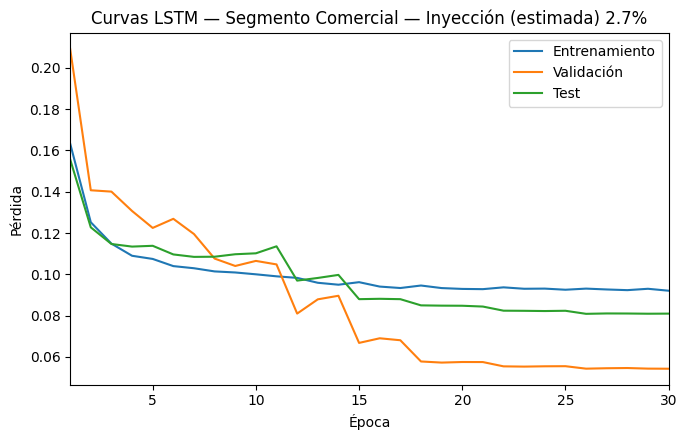


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 25: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 28: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1e-05.


c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


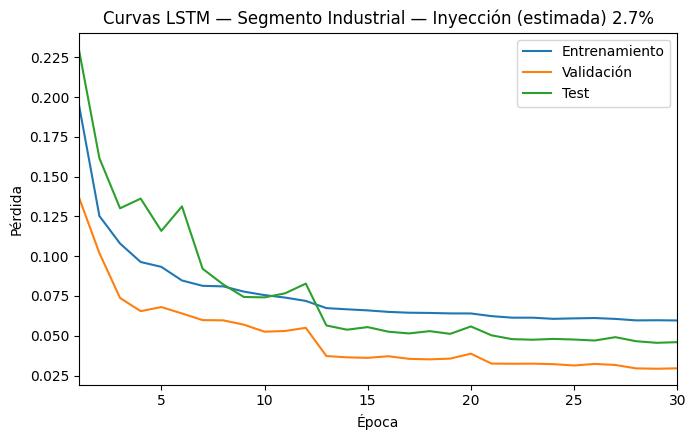


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


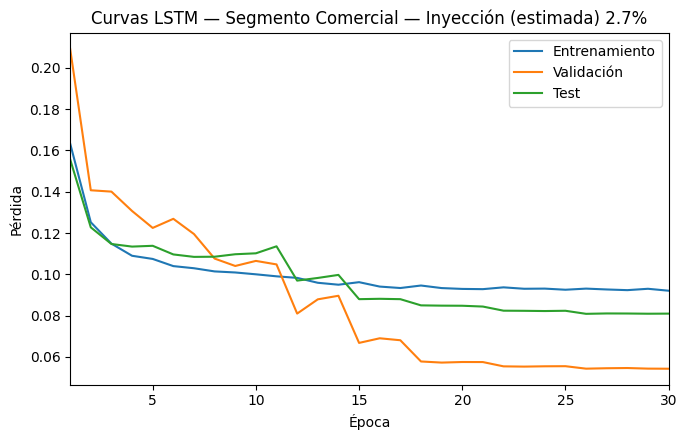

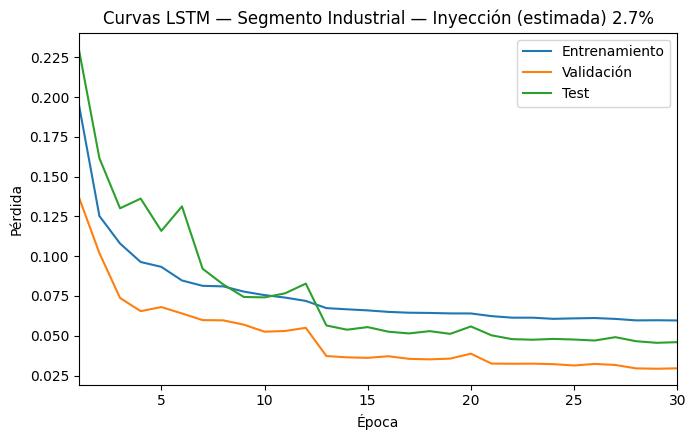

In [60]:
# LSTM — Model Training + Curvas
from IPython.display import display, DisplayHandle, clear_output

# ---------------------------------------------------------------------
# Convierte lo que venga (lista/ndarray/tensor) a escalar
# ---------------------------------------------------------------------
def _to_scalar(x) -> float:
    if x is None:
        return np.nan
    try:
        arr = np.asarray(x, dtype="float64")
        # Si ya es escalar
        if arr.ndim == 0:
            return float(arr)
        # Si es lista/array, devolvemos el promedio (ignora NaN)
        return float(np.nanmean(arr))
    except Exception:
        return np.nan

# ---------------------------------------------------------------------
# Construcción de secuencias por cliente
# ---------------------------------------------------------------------
def build_sequences_by_client(frame: pd.DataFrame,
                              seq_len: int,
                              seq_cols: List[str],
                              targets: List[str]) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    Xs, Ys, rows, clis = [], [], [], []
    for cli, g in frame.groupby("Cliente"):
        g = g.sort_values("Fecha")
        # to_numpy con dtype; si hay NaN se mantienen como np.nan
        A = g[seq_cols].to_numpy(dtype="float64")
        Y = g[targets].to_numpy(dtype="float64")
        idx = g.index.to_numpy()
        if len(g) <= seq_len:
            continue
        for i in range(len(g) - seq_len):
            Xs.append(A[i:i+seq_len]); Ys.append(Y[i+seq_len])
            rows.append(idx[i+seq_len]); clis.append(cli)
    if len(Xs) == 0:
        return (np.empty((0, seq_len, len(seq_cols))),
                np.empty((0, len(targets))),
                np.empty((0,), dtype=int),
                np.empty((0,), dtype=object))
    return (np.asarray(Xs, dtype="float64"),
            np.asarray(Ys, dtype="float64"),
            np.asarray(rows, dtype=int),
            np.asarray(clis, dtype=object))

# ---------------------------------------------------------------------
# Callback de curvas en vivo (sin convertir listas a float)
# ---------------------------------------------------------------------
class LiveCurvesCallback(callbacks.Callback):
    """
    Curvas train/val/test en tiempo real sin duplicados.
    """
    def __init__(self, X_test: np.ndarray, Y_test: np.ndarray, title: str):
        super().__init__()
        self.X_test = X_test
        self.Y_test = Y_test
        self.title = title
        self.train_losses: List[float] = []
        self.val_losses: List[float] = []
        self.test_losses: List[float] = []

        # Preparar figura
        self.fig, self.ax = plt.subplots(figsize=(7, 4.5))
        (self.line_tr,) = self.ax.plot([], [], label="Entrenamiento")
        (self.line_va,) = self.ax.plot([], [], label="Validación")
        (self.line_te,) = self.ax.plot([], [], label="Test")
        self.ax.set_xlabel("Época")
        self.ax.set_ylabel("Pérdida")
        self.ax.set_title(self.title)
        self.ax.legend()
        self.fig.tight_layout()
        self.handle: DisplayHandle | None = None

    def on_train_begin(self, logs=None):
        # Mostrar exactamente una vez y guardar el handle
        self.handle = DisplayHandle()
        self.handle.display(self.fig)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Usar _to_scalar en lugar de float()
        self.train_losses.append(_to_scalar(logs.get("loss")))
        self.val_losses.append(_to_scalar(logs.get("val_loss")))

        if self.X_test is not None and getattr(self.X_test, "shape", (0,))[0] > 0:
            test_eval = self.model.evaluate(self.X_test, self.Y_test, verbose=0)
            # evaluate puede devolver escalar o lista [loss, métricas...]
            if isinstance(test_eval, (list, tuple, np.ndarray)):
                test_loss = _to_scalar(test_eval[0])
            else:
                test_loss = _to_scalar(test_eval)
            self.test_losses.append(test_loss)
        else:
            self.test_losses.append(np.nan)

        # Actualizar datos de líneas
        x = np.arange(1, len(self.train_losses) + 1, dtype=float)
        self.line_tr.set_data(x, self.train_losses)
        if not np.all(np.isnan(self.val_losses)):
            self.line_va.set_data(x, self.val_losses)
        if not np.all(np.isnan(self.test_losses)):
            self.line_te.set_data(x, self.test_losses)

        # Ajuste de ejes robusto
        y_vals = [v for v in (*self.train_losses, *self.val_losses, *self.test_losses) if np.isfinite(v)]
        if y_vals:
            self.ax.set_xlim(1, max(2, len(x)))
            ymin, ymax = min(y_vals), max(y_vals)
            if ymin == ymax:
                ymax = ymin + 1e-6
            pad = 0.05 * (ymax - ymin)
            self.ax.set_ylim(ymin - pad, ymax + pad)

        # Redibujar y actualizar en el mismo output
        self.fig.canvas.draw_idle()
        if self.handle is not None:
            try:
                self.handle.update(self.fig)
            except Exception:
                self.handle = DisplayHandle()
                self.handle.display(self.fig)

# ---------------------------------------------------------------------
# Entrenamiento por segmento (sin cambios de workflow)
# ---------------------------------------------------------------------
lstm_models: Dict[str, models.Model] = {}
lstm_scalers: Dict[str, StandardScaler] = {}
lstm_Cinv: Dict[str, np.ndarray] = {}
lstm_meta: Dict[str, Dict[str, List[str]]] = {}

# Entradas del LSTM (señales + rasgos cíclicos)
SEQ_COLS = TARGETS + FEATS_TIME  # <- respeta tu workflow

def _resolve_injection_text() -> str:
    inj_label = globals().get("INJ_LABEL", None)
    if isinstance(inj_label, str) and inj_label.strip():
        base = inj_label.strip()
    else:
        rate = globals().get("ANOM_RATE", None)
        if isinstance(rate, (int, float, np.floating)) and np.isfinite(rate) and float(rate) > 0:
            base = f"Inyección {int(round(float(rate)*100))}%"
        else:
            anom_map = globals().get("anom_map_global", None)
            base_df = globals().get("full_train", None)
            if isinstance(anom_map, dict) and anom_map and isinstance(base_df, pd.DataFrame):
                total_inj = 0
                for v in anom_map.values():
                    if v is None: 
                        continue
                    if isinstance(v, (list, tuple, np.ndarray, pd.Series)):
                        total_inj += int(len(v))
                n_total = int(base_df.shape[0])
                if total_inj > 0 and n_total > 0:
                    pct = 100.0 * total_inj / n_total
                    base = f"Inyección (estimada) {pct:.1f}%"
                else:
                    base = "sin inyección/entrenamiento base"
            else:
                base = "sin inyección/entrenamiento base"
    kind = globals().get("INJ_KIND", None) or globals().get("INJ_SCENARIO", None)
    if isinstance(kind, str) and kind.strip():
        return f"{base} — {kind.strip()}"
    return base

_inj_text = _resolve_injection_text()

for seg in segments:
    tr = full_train[full_train["Segmento"] == seg].copy()
    te = full_test[full_test["Segmento"] == seg].copy()

    sc_seq = StandardScaler().fit(tr[SEQ_COLS].values)
    tr[SEQ_COLS] = sc_seq.transform(tr[SEQ_COLS])
    te_scaled = te.copy(); te_scaled[SEQ_COLS] = sc_seq.transform(te_scaled[SEQ_COLS])

    Xtr_seq, Ytr_seq, _, _ = build_sequences_by_client(tr, SEQ_LEN, SEQ_COLS, TARGETS)
    Xte_seq, Yte_seq, _, _ = build_sequences_by_client(te_scaled, SEQ_LEN, SEQ_COLS, TARGETS)
    if Xtr_seq.shape[0] == 0:
        print(f"[INFO] Segmento {seg}: sin suficientes secuencias (SEQ_LEN={SEQ_LEN}). Se omite.")
        continue

    """
    model = models.Sequential([
        layers.Input(shape=(SEQ_LEN, len(SEQ_COLS))),
        layers.LSTM(LSTM_UNITS1, return_sequences=True, dropout=0.2,
                    kernel_regularizer=regularizers.l2(1e-5)),
        layers.LayerNormalization(),
        layers.LSTM(LSTM_UNITS2, dropout=0.2,
                    kernel_regularizer=regularizers.l2(1e-5)),
        layers.LayerNormalization(),
        layers.Dense(DENSE_UNITS, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dense(len(TARGETS), activation="linear")
    ])
    """

    model = models.Sequential([
    layers.Input(shape=(SEQ_LEN, len(SEQ_COLS))),
    layers.LSTM(LSTM_UNITS1, return_sequences=True, dropout=0.2,
                kernel_regularizer=regularizers.l2(1e-5)),
    layers.LayerNormalization(),
    layers.LSTM(LSTM_UNITS2, dropout=0.2,
                kernel_regularizer=regularizers.l2(1e-5)),
    layers.LayerNormalization(),
    layers.Dense(DENSE_UNITS, kernel_regularizer=regularizers.l2(1e-5)),
    LeakyReLU(alpha=0.01),   # <- activación Leaky ReLU
    layers.Dense(len(TARGETS), activation="linear")
    ])

    opt = optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
    loss_fn = losses.Huber()  # robusta a outliers
    model.compile(optimizer=opt, loss=loss_fn, metrics=["mae"])

    live_cb = LiveCurvesCallback(Xte_seq, Yte_seq, title=f"Curvas LSTM — Segmento {seg} — {_inj_text}")

    es = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=EARLY_STOP_PATIENCE,
        restore_best_weights=True
    )
    rlrop = callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-5,
        verbose=1
    )

    history = model.fit(
        Xtr_seq, Ytr_seq,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.10,
        shuffle=False,                 # Series temporales no se barajan
        callbacks=[es, rlrop, live_cb],
        verbose=0
    )

    # Residuales y covarianza inversa estable para Mahalanobis
    Yhat_tr = model.predict(Xtr_seq, verbose=0)
    Etr = Ytr_seq - Yhat_tr
    Cinv = cov_inv_stable(Etr, ridge=1e-6)

    lstm_models[seg] = model
    lstm_scalers[seg] = sc_seq
    lstm_Cinv[seg] = Cinv
    lstm_meta[seg] = {"seq_cols": SEQ_COLS}


### Evaluación: Recall@FPR≈1% y Severidad

In [62]:
# Evaluation Functions
from typing import List, Tuple, Dict

def evaluate_ridge(seg: str,
                   test_df: pd.DataFrame,
                   anom_abs_map: Dict[str, List[int]]) -> Tuple[float, float]:
    Xte = test_df[RIDGE_XCOLS].values
    Yte = test_df[TARGETS].values
    sc = ridge_scalers[seg]; model = ridge_models[seg]; Cinv = ridge_Cinv[seg]

    Xte_s = sc.transform(Xte)
    Yhat = model.predict(Xte_s)
    E = Yte - Yhat
    scores = mahalanobis_rows(E, Cinv)

    recalls, sevs = [], []
    for cli, g in test_df.groupby("Cliente"):
        cli_str = str(cli)
        idx_cli = g.index.to_numpy()

        pos = test_df.index.get_indexer(idx_cli)
        valid = pos >= 0
        if not np.any(valid):
            continue
        pos = pos[valid]
        idx_cli_valid = idx_cli[valid]
        s_cli = scores[pos]

        anom_cli_abs = np.array(anom_abs_map.get(cli_str, []), dtype=int)
        anom_cli_abs = np.intersect1d(anom_cli_abs, idx_cli_valid, assume_unique=False)
        if anom_cli_abs.size == 0:
            continue

        rel_anom_mask = np.isin(idx_cli_valid, anom_cli_abs)
        rel_anom = np.where(rel_anom_mask)[0]
        rel_norm = np.where(~rel_anom_mask)[0]
        if rel_norm.size == 0:
            continue

        thr = threshold_at_fpr(s_cli, rel_norm, fpr=0.01)
        flags = (s_cli >= thr).astype(int)

        recalls.append(float(flags[rel_anom].mean()))
        sevs.append(float(s_cli[rel_anom].mean()))

    macro_recall = float(np.mean(recalls)) if recalls else np.nan
    mean_severity = float(np.mean(sevs)) if sevs else np.nan
    return macro_recall, mean_severity


def evaluate_if(seg: str,
                test_df: pd.DataFrame,
                anom_abs_map: Dict[str, List[int]]) -> Tuple[float, float]:
    sc = if_scalers[seg]; model = if_models[seg]

    Xte_if = test_df[IF_XCOLS].values
    Xte_if_s = sc.transform(Xte_if)
    raw = -model.decision_function(Xte_if_s)
    scores = np.abs(robust_z(raw))

    recalls, sevs = [], []
    for cli, g in test_df.groupby("Cliente"):
        cli_str = str(cli)
        idx_cli = g.index.to_numpy()

        pos = test_df.index.get_indexer(idx_cli)
        valid = pos >= 0
        if not np.any(valid):
            continue
        pos = pos[valid]
        idx_cli_valid = idx_cli[valid]
        s_cli = scores[pos]

        anom_cli_abs = np.array(anom_abs_map.get(cli_str, []), dtype=int)
        anom_cli_abs = np.intersect1d(anom_cli_abs, idx_cli_valid, assume_unique=False)
        if anom_cli_abs.size == 0:
            continue

        rel_anom_mask = np.isin(idx_cli_valid, anom_cli_abs)
        rel_anom = np.where(rel_anom_mask)[0]
        rel_norm = np.where(~rel_anom_mask)[0]
        if rel_norm.size == 0:
            continue

        thr = threshold_at_fpr(s_cli, rel_norm, fpr=0.01)
        flags = (s_cli >= thr).astype(int)

        recalls.append(float(flags[rel_anom].mean()))
        sevs.append(float(s_cli[rel_anom].mean()))

    macro_recall = float(np.mean(recalls)) if recalls else np.nan
    mean_severity = float(np.mean(sevs)) if sevs else np.nan
    return macro_recall, mean_severity


def evaluate_lstm(seg: str,
                  test_df_mod: pd.DataFrame,
                  anom_abs_map: Dict[str, List[int]]) -> Tuple[float, float]:
    model = lstm_models.get(seg, None)
    if model is None:
        return np.nan, np.nan

    seq_cols = lstm_meta[seg]["seq_cols"]
    sc_seq = lstm_scalers[seg]
    Cinv = lstm_Cinv[seg]

    te = test_df_mod.copy()
    te[seq_cols] = sc_seq.transform(te[seq_cols])

    Xte_seq, Yte_seq, row_ids, client_ids = build_sequences_by_client(te, SEQ_LEN, seq_cols, TARGETS)
    if Xte_seq.shape[0] == 0:
        return np.nan, np.nan

    Yhat_seq = model.predict(Xte_seq, verbose=0)
    E = Yte_seq - Yhat_seq
    scores = mahalanobis_rows(E, Cinv)

    recalls, sevs = [], []
    for cli in np.unique(client_ids):
        cli_str = str(cli)
        m = (client_ids == cli)
        rows_cli = row_ids[m]
        s_cli = scores[m]

        anom_cli_abs = np.array(anom_abs_map.get(cli_str, []), dtype=int)
        anom_cli_abs = np.intersect1d(anom_cli_abs, rows_cli, assume_unique=False)
        if rows_cli.size == 0 or anom_cli_abs.size == 0:
            continue

        rel_anom_mask = np.isin(rows_cli, anom_cli_abs) 
        rel_anom = np.where(rel_anom_mask)[0]
        rel_norm = np.where(~rel_anom_mask)[0]
        if rel_norm.size == 0:
            continue

        thr = threshold_at_fpr(s_cli, rel_norm, fpr=0.01)
        flags = (s_cli >= thr).astype(int)

        recalls.append(float(flags[rel_anom].mean()))
        sevs.append(float(s_cli[rel_anom].mean()))

    macro_recall = float(np.mean(recalls)) if recalls else np.nan
    mean_severity = float(np.mean(sevs)) if sevs else np.nan
    return macro_recall, mean_severity

### Ejecución de Evaluación (1% y 5%) y Consolidación de Resultados

In [63]:
# Run Evaluación por escenario
rows_summary = []

for rate in ANOM_RATES:
    # Se inyecta sobre una copia del test global, por segmento y cliente
    test_mod = full_test.copy()
    anom_map_global: Dict[str, np.ndarray] = {}

    for seg in segments:
        seg_test = test_mod[test_mod["Segmento"] == seg]
        seg_test_mod, seg_map = inject_anomalies_by_client(seg_test, rate=rate, seg_stats=seg_stats, min_gap=24)

        # Reemplaza en el test_mod global
        test_mod.loc[seg_test_mod.index, ["Volumen","Presion","Temperatura"]] = seg_test_mod[["Volumen","Presion","Temperatura"]]

        # Fusiona mapas por cliente
        for cli, idxs in seg_map.items():
            if cli not in anom_map_global:
                anom_map_global[cli] = idxs
            else:
                anom_map_global[cli] = np.unique(np.concatenate([anom_map_global[cli], idxs]))

    # Evaluación por modelo y por segmento; agregado macro-promedio simple de segmentos
    rec_ridge_seg, sev_ridge_seg = [], []
    rec_if_seg, sev_if_seg = [], []
    rec_lstm_seg, sev_lstm_seg = [], []

    for seg in segments:
        seg_test_mod = test_mod[test_mod["Segmento"] == seg]
        # Construir mapas por cliente, restringidos al segmento actual
        seg_clients = seg_test_mod["Cliente"].unique()
        seg_map = {cli: np.intersect1d(anom_map_global.get(cli, np.array([], dtype=int)), seg_test_mod.index.to_numpy(), assume_unique=False)
                   for cli in seg_clients}

        r1, s1 = evaluate_ridge(seg, seg_test_mod, seg_map)
        r2, s2 = evaluate_if(seg, seg_test_mod, seg_map)
        r3, s3 = evaluate_lstm(seg, seg_test_mod, seg_map)

        rec_ridge_seg.append(r1); sev_ridge_seg.append(s1)
        rec_if_seg.append(r2);    sev_if_seg.append(s2)
        rec_lstm_seg.append(r3);  sev_lstm_seg.append(s3)

    # Macro-promedios sobre segmentos (ignora NaN)
    def mean_ignore_nan(x): 
        x = np.array(x, float); x = x[~np.isnan(x)]
        return float(np.mean(x)) if len(x) else np.nan

    rows_summary.append(("Ridge+Lags (3-var)", rate, mean_ignore_nan(rec_ridge_seg), mean_ignore_nan(sev_ridge_seg)))
    rows_summary.append(("IsolationForest+TimeFeats", rate, mean_ignore_nan(rec_if_seg), mean_ignore_nan(sev_if_seg)))
    rows_summary.append(("LSTM (seq2one)", rate, mean_ignore_nan(rec_lstm_seg), mean_ignore_nan(sev_lstm_seg)))

res_df = pd.DataFrame(rows_summary, columns=["Modelo","Tasa_inyeccion","Recall@1%FPR","Severidad_media"])
display(res_df)

c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,Modelo,Tasa_inyeccion,Recall@1%FPR,Severidad_media
0,Ridge+Lags (3-var),0.01,0.685908,47.418576
1,IsolationForest+TimeFeats,0.01,0.012861,1.345264
2,LSTM (seq2one),0.01,0.495753,20.200387
3,Ridge+Lags (3-var),0.05,0.703264,44.383582
4,IsolationForest+TimeFeats,0.05,0.016587,1.288720
5,LSTM (seq2one),0.05,0.515041,17.735357


### Barplot

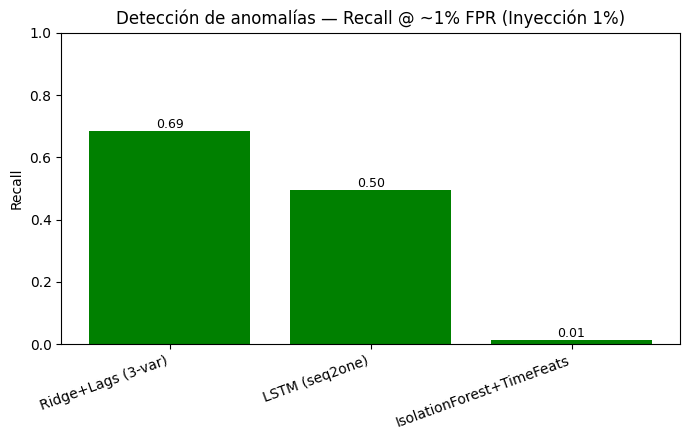

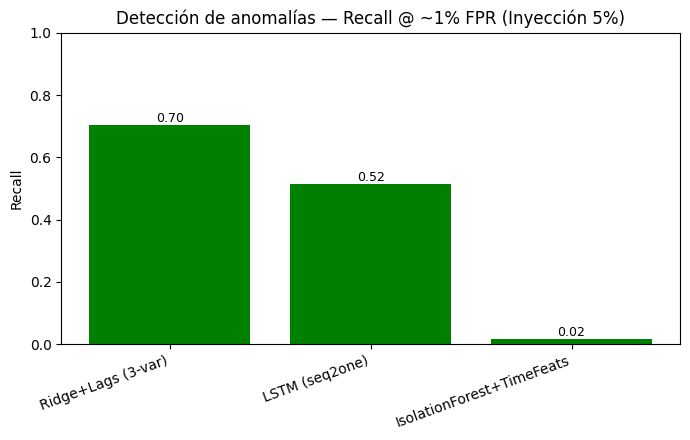

In [64]:
# Bar Plots
from matplotlib.patches import Rectangle
for rate in ANOM_RATES:
    subset = res_df[res_df["Tasa_inyeccion"] == rate].sort_values("Recall@1%FPR", ascending=False)
    if subset.empty:
        continue  # nada que graficar para este escenario

    fig, ax = plt.subplots(figsize=(7, 4.5))
    bars = ax.bar(
        subset["Modelo"].to_numpy(),
        subset["Recall@1%FPR"].to_numpy(),
        color="green"
    )
    ax.set_title(f"Detección de anomalías — Recall @ ~1% FPR (Inyección {int(rate*100)}%)")
    ax.set_ylabel("Recall")
    ax.set_ylim(0, 1)

    # Anotar cada barra de forma segura
    for rect in bars:
        if isinstance(rect, Rectangle):
            h = rect.get_height()
            if np.isfinite(h):
                ax.text(rect.get_x() + rect.get_width() / 2.0,
                        h,
                        f"{h:.2f}",
                        ha="center", va="bottom", fontsize=9)

    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

### Utilidades de Exportación de Resultados

In [67]:
# Exportación de resultados detallados por modelo y escenario
from typing import Dict, List
from pathlib import Path

OUTPUT_DIR = Path("exports_scores")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def _export_dataframe(df_out: pd.DataFrame, fname: str) -> Path:
    path = OUTPUT_DIR / fname
    df_out.to_csv(path, index=False, encoding="utf-8-sig")
    return path

def _per_client_threshold_and_flags(scores: np.ndarray,
                                   idx_abs: np.ndarray,
                                   df_seg: pd.DataFrame,
                                   anom_abs_map: Dict[str, List[int]],
                                   fpr_target: float = 0.01) -> pd.DataFrame:
    """
    Calcula umbral por cliente a FPR objetivo y devuelve DataFrame con:
    Fecha, Cliente, Segmento, Score, Flag, Umbral, EsAnomaliaSintetica.
    anom_abs_map: dict con llaves str(cliente) y valores list[int] de índices absolutos anómalos.
    """
    out_rows = []
    idx_abs_sorted = np.sort(np.array(idx_abs, dtype=int))
    scores_aligned = scores  # alineado a idx_abs_sorted vía searchsorted

    for cli, g in df_seg.groupby("Cliente"):
        cli_str = str(cli)

        idx_cli_abs = g.index.to_numpy()
        inter = np.intersect1d(idx_cli_abs, idx_abs_sorted, assume_unique=False)
        if inter.size == 0:
            continue

        pos = np.searchsorted(idx_abs_sorted, inter)
        s_cli = scores_aligned[pos]

        # Etiquetas sintéticas (usar lista por defecto y llave normalizada)
        anom_cli_list = anom_abs_map.get(cli_str, [])
        anom_cli_abs = np.array(anom_cli_list, dtype=int)
        anom_cli_abs = np.intersect1d(anom_cli_abs, inter, assume_unique=False)

        rel_all = np.arange(inter.size)
        rel_anom = np.searchsorted(inter, anom_cli_abs)
        rel_norm = np.setdiff1d(rel_all, rel_anom, assume_unique=False)

        if rel_norm.size > 0:
            thr = threshold_at_fpr(s_cli, rel_norm, fpr=fpr_target)
        else:
            thr = float(np.quantile(s_cli, 0.99))  # fallback si no hay normales

        flags = (s_cli >= thr).astype(int)

        es_anom = np.zeros(inter.size, dtype=int)
        if rel_anom.size > 0:
            es_anom[rel_anom] = 1

        block = pd.DataFrame({
            "Fecha": df_seg.loc[inter, "Fecha"].values,
            "Cliente": df_seg.loc[inter, "Cliente"].values,
            "Segmento": df_seg.loc[inter, "Segmento"].values,
            "Score": s_cli,    # Residuo entre lo observado y lo predicho, es un error
            "Flag_Model": flags,
            "Umbral": np.full(inter.size, thr),   # Score > Umbral, se marca como anomalía
            "EsAnomaliaSintetica": es_anom
        }, index=inter).sort_index()

        out_rows.append(block)

    if not out_rows:
        return pd.DataFrame(columns=["Fecha","Cliente","Segmento","Score","Flag_Model","Umbral","EsAnomaliaSintetica"])

    return pd.concat(out_rows, axis=0)

### Exportar CSVs por Escenario y Modelo (+ archivo consolidado)

In [68]:
# EXPORT RUN — Por escenario y modelo
exports_summary = []

for rate in ANOM_RATES:
    test_mod = full_test.copy()
    anom_map_global: Dict[str, np.ndarray] = {}

    for seg in segments:
        seg_test = test_mod[test_mod["Segmento"] == seg]
        seg_test_mod, seg_map = inject_anomalies_by_client(
            seg_test, rate=rate, seg_stats=seg_stats, min_gap=24
        )

        test_mod.loc[seg_test_mod.index, ["Volumen","Presion","Temperatura"]] = seg_test_mod[["Volumen","Presion","Temperatura"]]

        for cli, idxs in seg_map.items():
            if cli not in anom_map_global:
                anom_map_global[cli] = idxs
            else:
                anom_map_global[cli] = np.unique(np.concatenate([anom_map_global[cli], idxs]))

    # >>> Normalización del mapa de anomalías a Dict[str, List[int]]
    anom_map_global_list: Dict[str, List[int]] = {
        str(k): (v.tolist() if isinstance(v, np.ndarray) else [int(x) for x in v])
        for k, v in anom_map_global.items()
    }

    all_rows = []

    # ---------------------- RIDGE ----------------------
    model_key = "Ridge+Lags (3-var)"
    for seg in segments:
        seg_df = test_mod[test_mod["Segmento"] == seg]
        if len(seg_df) == 0:
            continue

        Xte = seg_df[RIDGE_XCOLS].values
        Yte = seg_df[TARGETS].values
        sc = ridge_scalers[seg]; model = ridge_models[seg]; Cinv = ridge_Cinv[seg]

        Xte_s = sc.transform(Xte)
        Yhat = model.predict(Xte_s)
        E = Yte - Yhat
        scores = mahalanobis_rows(E, Cinv)

        df_export = _per_client_threshold_and_flags(
            scores=scores,
            idx_abs=seg_df.index.to_numpy(),
            df_seg=seg_df,
            anom_abs_map=anom_map_global_list,  # <--- corregido
            fpr_target=0.01
        )
        if df_export.empty:
            continue
        df_export.insert(0, "Modelo", model_key)
        df_export.insert(1, "Tasa_inyeccion", rate)
        all_rows.append(df_export)

    # ------------------ ISOLATION FOREST ------------------
    model_key = "IsolationForest+TimeFeats"
    for seg in segments:
        seg_df = test_mod[test_mod["Segmento"] == seg]
        if len(seg_df) == 0:
            continue

        Xte_if = seg_df[IF_XCOLS].values
        sc_if = if_scalers[seg]; iso = if_models[seg]
        Xte_if_s = sc_if.transform(Xte_if)
        raw = -iso.decision_function(Xte_if_s)
        scores = np.abs(robust_z(raw))

        df_export = _per_client_threshold_and_flags(
            scores=scores,
            idx_abs=seg_df.index.to_numpy(),
            df_seg=seg_df,
            anom_abs_map=anom_map_global_list,  # <--- corregido
            fpr_target=0.01
        )
        if df_export.empty:
            continue
        df_export.insert(0, "Modelo", model_key)
        df_export.insert(1, "Tasa_inyeccion", rate)
        all_rows.append(df_export)

    # ------------------------- LSTM -------------------------
    model_key = "LSTM (seq2one)"
    for seg in segments:
        if seg not in lstm_models:
            continue

        seg_df = test_mod[test_mod["Segmento"] == seg].copy()
        if len(seg_df) == 0:
            continue

        seq_cols = lstm_meta[seg]["seq_cols"]
        sc_seq = lstm_scalers[seg]
        Cinv = lstm_Cinv[seg]
        model = lstm_models[seg]

        seg_df_scaled = seg_df.copy()
        seg_df_scaled[seq_cols] = sc_seq.transform(seg_df_scaled[seq_cols])

        X_seq, Y_seq, row_ids, client_ids = build_sequences_by_client(
            seg_df_scaled, SEQ_LEN, seq_cols, TARGETS
        )
        if X_seq.shape[0] == 0:
            continue

        Yhat_seq = model.predict(X_seq, verbose=0)
        E = Y_seq - Yhat_seq
        scores = mahalanobis_rows(E, Cinv)

        df_sub = seg_df.loc[row_ids].copy()
        df_export = _per_client_threshold_and_flags(
            scores=scores,
            idx_abs=row_ids,
            df_seg=df_sub,
            anom_abs_map=anom_map_global_list,
            fpr_target=0.01
        )
        if df_export.empty:
            continue
        df_export.insert(0, "Modelo", model_key)
        df_export.insert(1, "Tasa_inyeccion", rate)
        all_rows.append(df_export)

    # ------------------ Escritura de archivos ------------------
    if all_rows:
        combo = pd.concat(all_rows, axis=0).sort_values(["Modelo","Cliente","Fecha"]).reset_index(drop=True)
        fname_all = f"scores_flags_ALL_{int(rate*100)}pct.csv"
        path_all = _export_dataframe(combo, fname_all)
        exports_summary.append({"Escenario": f"{int(rate*100)}%", "Archivo": str(path_all), "Filas": len(combo)})

        for model_name in combo["Modelo"].unique():
            sub = combo[combo["Modelo"] == model_name].copy()
            fname = f"scores_flags_{model_name.replace(' ','_').replace('(','').replace(')','').replace('+','plus')}_{int(rate*100)}pct.csv"
            path = _export_dataframe(sub, fname)
            exports_summary.append({"Escenario": f"{int(rate*100)}%", "Archivo": str(path), "Filas": len(sub)})

# Resumen de exportación
exports_df = pd.DataFrame(exports_summary)
display(exports_df)

c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\julio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,Escenario,Archivo,Filas
0,1%,exports_scores\scores_flags_ALL_1pct.csv,759840
1,1%,exports_scores\scores_flags_IsolationForestplu...,253376
2,1%,exports_scores\scores_flags_LSTM_seq2one_1pct.csv,253088
3,1%,exports_scores\scores_flags_RidgeplusLags_3-va...,253376
4,5%,exports_scores\scores_flags_ALL_5pct.csv,759840
5,5%,exports_scores\scores_flags_IsolationForestplu...,253376
6,5%,exports_scores\scores_flags_LSTM_seq2one_5pct.csv,253088
7,5%,exports_scores\scores_flags_RidgeplusLags_3-va...,253376


In [38]:
#%pip install session-info
import session_info
session_info.show(dependencies=False)  # avoids the lookup that triggers the KeyError